In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir drive
!google-drive-ocamlfuse drive

mkdir: cannot create directory ‘drive’: File exists
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [3]:
import os 
os.chdir("/content/drive")

In [4]:
import os 
os.chdir("/content/drive/Colab_Notebooks/2december")
!pwd

/content/drive/Colab_Notebooks/2december


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
dtrain = pd.read_csv('train.csv')
dtrain.head(20)

In [7]:

# ÖN İŞLEMLER

def preprocess(data):
    
    #Kabin
    data.Cabin.fillna('0', inplace=True)
    data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
    data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
    data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
    data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
    data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
    data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
    data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
    data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8
    
    # Cinsiyeti tam sayıya çevirelim
    data['Sex'].replace('female', 1, inplace=True)
    data['Sex'].replace('male', 2, inplace=True)
    
    # Gemiye biniş limanlarını tam sayıya çevirelim
    data['Embarked'].replace('S', 1, inplace=True)
    data['Embarked'].replace('C', 2, inplace=True)
    data['Embarked'].replace('Q', 3, inplace=True)
    
    # Olmayan (NA) yaş değerlerini medyan ile dolduralım
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].median(), inplace=True)
    
    # İstersek olmayan (NA) değerleri tamamen silebiliriz
    # data.dropna(subset=['Fare', 'Embarked'], inplace=True, how='any')
    return data

def group_titles(data):
    data['Names'] = data['Name'].map(lambda x: len(re.split(' ', x)))
    data['Title'] = data['Name'].map(lambda x: re.search(', (.+?) ', x).group(1))
    data['Title'].replace('Master.', 0, inplace=True)
    data['Title'].replace('Mr.', 1, inplace=True)
    data['Title'].replace(['Ms.','Mlle.', 'Miss.'], 2, inplace=True)
    data['Title'].replace(['Mme.', 'Mrs.'], 3, inplace=True)
    data['Title'].replace(['Dona.', 'Lady.', 'the Countess.', 'Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'the'], 4, inplace=True)

def data_subset(data):

    features = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Names', 'Title', 'Age', 'Cabin'] #, 'Fare', 'Embarked']
    lengh_features = len(features)
    subset = data[features]#.fillna(0)
    return subset, lengh_features

def create_model(train_set_size, input_length, num_epochs, batch_size):
    model = Sequential()
    model.add(Dense(7, input_dim=input_length, activation='softplus'))
    model.add(Dense(3, activation='softplus'))
    model.add(Dense(1, activation='softplus'))

    lr = .001
    adam0 = Adam(lr = lr)

    # Modeli derleyip ve daha iyi bir sonuç elde edildiğinde ağırlıkları kaydedelim
    model.compile(loss='binary_crossentropy', optimizer=adam0, metrics=['accuracy'])
    filepath = 'weights.best.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    history_model = model.fit(X_train[:train_set_size], Y_train[:train_set_size], callbacks=callbacks_list, epochs=num_epochs, batch_size=batch_size, verbose=0) #40, 32
    return model, history_model

def calculation_storage (history):
  temp_loss=[]
  temp_acc=[]
  loss_history = history.history['loss']
  acc_history = history.history['accuracy']
  temp_loss=temp_loss+[loss_history]
  temp_acc=temp_acc+[acc_history]

  return (temp_loss), (temp_acc)

def plots(loss_history,acc_history, num_epochs, batchdata):

  line_info = batchdata
  loss_history = loss_history
  acc_history = acc_history
  print('koddasın')


  epochs = [(i + 1) for i in range(num_epochs)]
  count= len(loss_history)
  print(loss_history)
  print(acc_history)
  print(epochs)


  ax=plt.subplot(211)
  bx=plt.subplot(212)

  for k in range((count)):
    ax.plot( epochs ,loss_history[k][:],label = line_info[k])
  ax.set_xlabel('x - axis')
  ax.set_ylabel('y - axis')
  ax.set_title('Loss Function vs Epochs')

  for k in range((count)):
    bx.plot(epochs , acc_history[k][:], label = line_info[k])
  bx.set_xlabel('x - axis')
  bx.set_ylabel('y - axis')
  bx.set_title('Accuracy vs Epochs ')

  plt.subplots_adjust(hspace=0.8)
  plt.legend(loc='best')
 
  plt.savefig('Accuracy_loss_batches.png')


  plt.show()
  plt.close()
   


In [9]:
def test_method(batch_size):
    total_output = []  # assigned for return value
    batch_size = batch_size
    print(batch_size)
    test = pd.read_csv('test.csv', header=0)
    test_ids = test['PassengerId']
    test = preprocess(test)
    group_titles(test)
    testdata, _ = data_subset(test)

    X_test = np.array(testdata).astype(float)
    output = model.predict(X_test, batch_size=batch_size, verbose=0)
    output = output.reshape((418,))

     #Sonuçları ondalık sayı yerine 0-1 olarak değiştirebilirsiniz
    outputBin = np.zeros(0)
    for element in output:
        if element <= .5:
             outputBin = np.append(outputBin, False)
        else:
            outputBin = np.append(outputBin, True)
    output1 = np.array(outputBin).astype(bool)

    #column_1 = np.concatenate((['PassengerId'], test_ids ), axis=0 )


    #column_2 = np.concatenate( ( ['Survived'], output ), axis=0 )
    #column_3 = np.concatenate ( ( ['Result'], output1 ), axis=0)

    total_output = total_output + [output]
    total_output = total_output + [output1]
    print(batch_size)
    print(output1)
    print(batch_size)
    print(output1)

    return (total_output) 


In [10]:
def csv_writer(txt,batch_rows):
  print(txt)
  text = txt
  array = batch_rows

  for j in range(len(text)):
    x = text[j]
    csv_input = pd.read_csv('myresults.csv')
    csv_input[x] = array[j]
    csv_input.to_csv('myresults.csv', index=False)


In [ ]:
dtrain.head(10)
group_titles(dtrain)
dtrain.head(5)


Epoch 00001: accuracy improved from -inf to 0.39262, saving model to weights.best.hdf5

Epoch 00002: accuracy did not improve from 0.39262

Epoch 00003: accuracy did not improve from 0.39262

Epoch 00004: accuracy did not improve from 0.39262

Epoch 00005: accuracy did not improve from 0.39262

Epoch 00006: accuracy did not improve from 0.39262

Epoch 00007: accuracy improved from 0.39262 to 0.41946, saving model to weights.best.hdf5

Epoch 00008: accuracy improved from 0.41946 to 0.62081, saving model to weights.best.hdf5

Epoch 00009: accuracy did not improve from 0.62081

Epoch 00010: accuracy did not improve from 0.62081

Epoch 00011: accuracy did not improve from 0.62081

Epoch 00012: accuracy did not improve from 0.62081

Epoch 00013: accuracy did not improve from 0.62081

Epoch 00014: accuracy did not improve from 0.62081

Epoch 00015: accuracy did not improve from 0.62081

Epoch 00016: accuracy did not improve from 0.62081

Epoch 00017: accuracy improved from 0.62081 to 0.6258

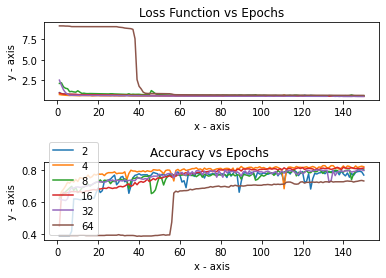

validasyon part:
148/148 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.7797
loss_and_metrics: [0.5911241769790649, 0.7796609997749329]
2
2
2
[False False False False  True False False False  True False False False
  True False  True  True False False False False False False False False
  True False  True False False False False False  True  True  True False
 False False False False False  True False  True  True False False False
  True  True  True False False  True False False False  True False  True
 False False False False False  True False False  True  True False False
 False  True  True  True False  True False False False False False False
 False False False False False  True  True False  True False False False
 False False  True False  True False False False  True False False False
 False  True False False False False  True False False  True  True  True
  True False  True False False  True False False False False False  True
  True False False False F

In [13]:
# sonuçların yeniden üretilebilir olması için
seed = 7
np.random.seed(seed)


train = pd.read_csv('train.csv', header=0)


preprocess(train)
group_titles(train)


num_epochs = 150
batch_data = [2,4,8,16,32,64]
temp_x=[]
temp_y=[]


traindata, lengh_features = data_subset(train)

Y_train = np.array(train['Survived']).astype(int)
X_train = np.array(traindata).astype(float)


train_set_size = int(.67 * len(X_train))

for element in batch_data:
  model, history_model = create_model(train_set_size, lengh_features, num_epochs, element)

  a = history_model.history['loss']
  b = history_model.history['accuracy']
  temp_x=temp_x+[a]
  temp_y=temp_y+[b]

loss_history = temp_x
acc_history = temp_y
print(loss_history)
print(acc_history)

plots(loss_history,acc_history,num_epochs,batch_data)


X_validation = X_train[train_set_size:]
Y_validation = Y_train[train_set_size:]


test = pd.read_csv('test.csv', header=0)
test_ids = test['PassengerId']
column_1 = np.concatenate((['PassengerId'], test_ids ), axis=0 )

f = open("myresults.csv", "w")
writer = csv.writer(f)

for i in range(len(test_ids)+1):
  writer.writerow([column_1[i]])
f.close()

batch_rows = []

for element in batch_data:
  print("validasyon part:")
  loss_and_metrics = model.evaluate(X_validation , Y_validation, batch_size=element)
  print ("loss_and_metrics:", loss_and_metrics)
  print(element)
  batch_row = test_method(element)
  batch_rows = batch_rows + batch_row
  #a = a + [a]  #survived
  #b = b + [b]  #result
  
txt_arr=[]
  
for x in batch_data:
  srv_tmp = 'survived - ' + str(x) + 'th epoch'
  txt_arr = txt_arr + [srv_tmp]
  rst_tmp = 'result - ' + str(x) + 'th epoch'
  txt_arr = txt_arr + [rst_tmp]
  



csv_writer(txt_arr,batch_rows)




In [ ]:
batch_rows[2]

Why there is 'batch-size' option in the model.evaluate()



Okay, I can see now where your confusion is coming from...

For one, some models in Keras require a fixed batch size even during prediction/evaluation. This is true for stateful RNNs, for example, since they keep information from one batch to the next (and the position of a sample within a batch is important!). According to the docs it's also the case for RNNs with Dropout when using the Tensorflow backend, presumably for technical reasons in the implementation.

If this doesn't apply to your model, it's true that setting a batch_size isn't technically needed. I believe it can affect the runtime performance of your model though, since it's basically controlling how much data is fed to your GPU at a time (= in one batch).

This is how I understand things at least. 

Comment from: https://github.com/keras-team/keras/issues/3027